In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

In [4]:
df = pd.read_parquet('Ventas.parquet')

## Exploración:

In [5]:
df.head(5)

,Centro,Año/Mes,Material,Cantidad,Artículo,TALLA,COLOR
0,T083,2022|10,4224231,1.0,CAMISETA,3T,Rosado 11-1408
1,FN50,2022|10,4224231,1.0,CAMISETA,3T,Rosado 11-1408
2,T084,2023|1,4224231,1.0,CAMISETA,3T,Rosado 11-1408
3,T049,2023|1,4224231,1.0,CAMISETA,3T,Rosado 11-1408
4,T097,2022|12,4224231,1.0,CAMISETA,3T,Rosado 11-1408


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6462432 entries, 0 to 6462431
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Centro    object 
 1   Año/Mes   object 
 2   Material  object 
 3   Cantidad  float64
 4   Artículo  object 
 5   TALLA     object 
 6   COLOR     object 
dtypes: float64(1), object(6)
memory usage: 345.1+ MB


Cantidad de registros:

In [7]:
df.shape

(6462432, 7)

Número de categorias por variable:

In [8]:
df.nunique()

Centro        129
Año/Mes        25
Material    11464
Cantidad       12
Artículo       37
TALLA          85
COLOR        1044
dtype: int64

Registros nulos:

In [9]:
df.isnull().sum()

Centro           0
Año/Mes          0
Material         0
Cantidad         0
Artículo    129277
TALLA       135945
COLOR       135945
dtype: int64

Observemos un poco la distribución de nuestra variable objetivo:

In [10]:
df["Cantidad"].value_counts()

Cantidad
 1.0     6171655
-1.0      261074
 0.0       28563
-2.0         914
-3.0         139
-4.0          48
-5.0          17
 2.0          16
-6.0           3
-11.0          1
 3.0           1
-10.0          1
Name: count, dtype: int64

Si quisiera hacer un modelo predictivo para las cantidades se tiene que tener en cuenta que el número de muestras por categoría es muy diferente, a eso se le conoce como desbalanceo, a demás de eso veo unas categorías que pueden hacer un poco de ruido como por ejemplo -10, 3 y -11 los cuales aparecen de a un solo dato, por ende reagruparé esta variable entre grupos, cantidades positivas, cantidades cero y cantidades negativas, posteriormente haré un balanceo o undersampling para equilibrar las muestras y tratar de observar tendencias.

In [11]:
def get_cat(row):
    if row >0:
        return "Cant_pos"
    elif row <0:
        return "Cant_neg"
    else:
        return "Cant_cero"

df["Re_cantidad"] = df["Cantidad"].apply(get_cat)

In [12]:
df["Re_cantidad"].value_counts()

Re_cantidad
Cant_pos     6171672
Cant_neg      262197
Cant_cero      28563
Name: count, dtype: int64

Note algo interesante:

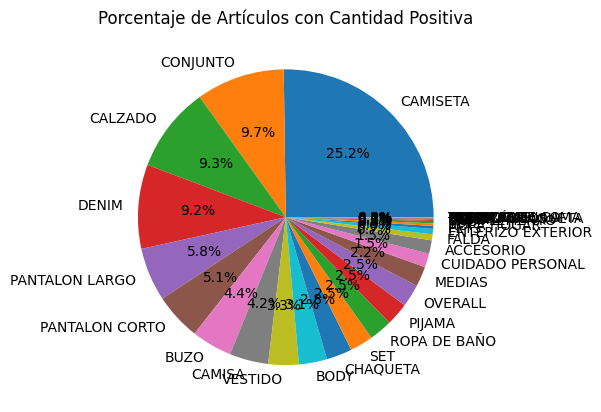

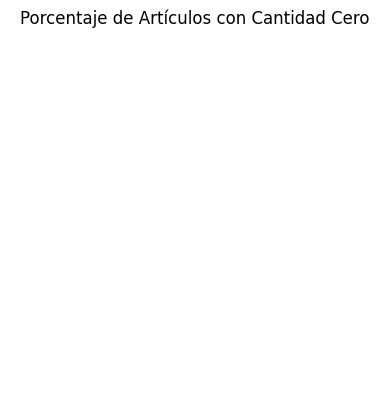

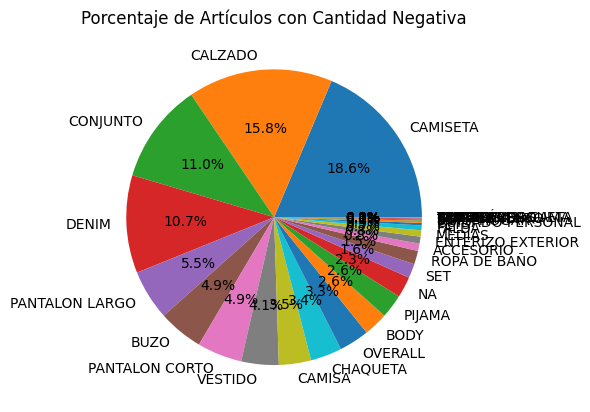

In [13]:

df[df["Re_cantidad"]=="Cant_pos"]["Artículo"].value_counts().reset_index().pipe(
    lambda df: plt.pie(df["count"], labels=df["Artículo"], autopct="%1.1f%%")
                                                                                )
plt.title('Porcentaje de Artículos con Cantidad Positiva')

plt.show()

df[df["Re_cantidad"]=="Cant_cero"]["Artículo"].value_counts().reset_index().pipe(
    lambda df: plt.pie(df["count"], labels=df["Artículo"], autopct="%1.1f%%")
                                                                                )
plt.title('Porcentaje de Artículos con Cantidad Cero')


plt.show()
df[df["Re_cantidad"]=="Cant_neg"]["Artículo"].value_counts().reset_index().pipe(
    lambda df: plt.pie(df["count"], labels=df["Artículo"], autopct="%1.1f%%")
                                                                                )
plt.title('Porcentaje de Artículos con Cantidad Negativa')
plt.show()



1. En las cantidades negativas, los artículos de calzado y conjunto aumentan un poco su proporción, mientras que las camisas disminuyen, esto cuando comparamos con las cantidades positivas.

2. Haciendo este mismo ejercicio no trajo valores para las cantidades de cero, a continuación observaremos esto con detalle.

In [14]:
print("Tenemos un total de "+ str(df[df["Re_cantidad"]=="Cant_cero"].shape[0]) + " registros con cantidad cero")

Tenemos un total de 28563 registros con cantidad cero


In [15]:
df[df["Re_cantidad"]=="Cant_cero"].isnull().sum()

Centro             0
Año/Mes            0
Material           0
Cantidad           0
Artículo       28563
TALLA          28563
COLOR          28563
Re_cantidad        0
dtype: int64

Y observe que los artículos con cantidad cero tanto las variables de Artículo, Talla y Color no hay registros, por lo que no podremos cruzar estas variables para observar tendencias

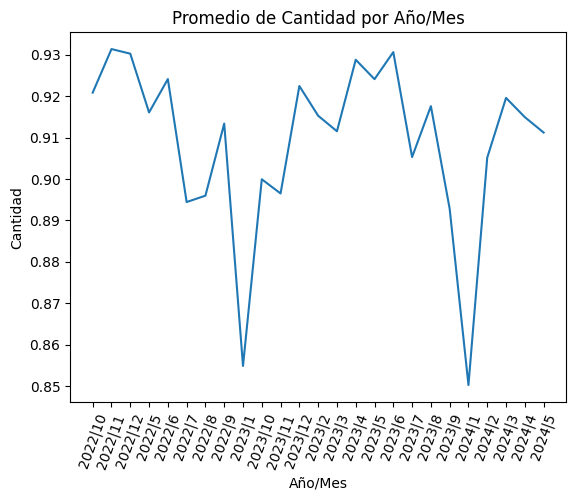

In [16]:
df.groupby("Año/Mes")["Cantidad"].mean().reset_index().pipe(
    lambda df: sns.lineplot(data=df, x="Año/Mes", y="Cantidad")
)
plt.xticks(rotation=70)
plt.title('Promedio de Cantidad por Año/Mes')
# Mostrar el gráfico
plt.show()

Haciendo un análisis para ver el comportamiento para ver como se mueve la cantidad promedio a lo largo del tiempo parece moverse muy cercano a 1 en la mayoría de meses, a simple vista se notan dos valles en estos meses.

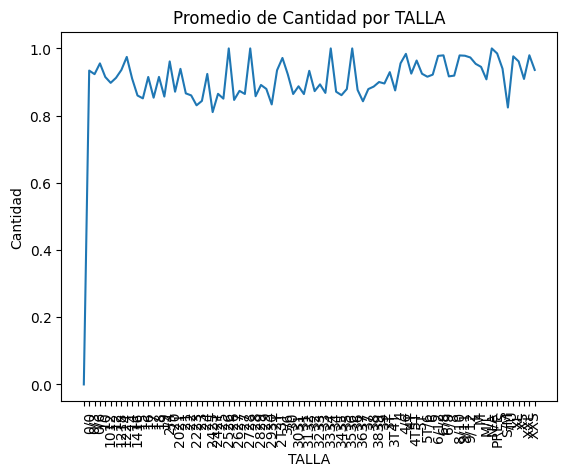

In [17]:
df.groupby("TALLA")["Cantidad"].mean().reset_index().pipe(
    lambda df: sns.lineplot(data=df, x="TALLA", y="Cantidad")
)
plt.xticks(rotation=90)
plt.title('Promedio de Cantidad por TALLA')
# Mostrar el gráfico
plt.show()

In [18]:
df.groupby("TALLA")["Cantidad"].mean().reset_index().head(3)

,TALLA,Cantidad
0,,0.000000
1,0/0,0.934071
2,0/3,0.923404


Aparentemente, las tallas pareciera que no tienen demasiada influencia sobre la cantidad, ese valle es resultado de agrupar valores nulos, lo cual tampoco da mucha información

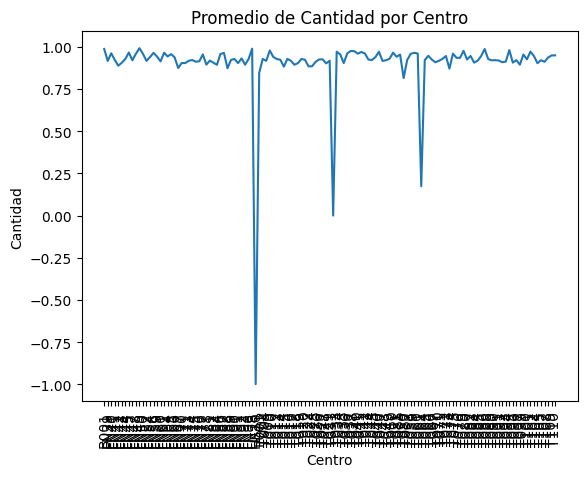

In [19]:
df.groupby("Centro")["Cantidad"].mean().reset_index().pipe(
    lambda df: sns.lineplot(data=df, x="Centro", y="Cantidad")
)
plt.xticks(rotation=90)
plt.title('Promedio de Cantidad por Centro')
# Mostrar el gráfico
plt.show()

Se nota la presencia de unos valles, es decir que en promedio en la mayoría de centros se mantiene en 1, pero hay algunos centros que están por debajo del promedio, a continuación buscaré estos centros en específico.

In [20]:
df.groupby("Centro")["Cantidad"].mean().reset_index().pipe(
    lambda df: df[df["Cantidad"]<0.2]
)

,Centro,Cantidad
43,HE10,-0.998768
65,T031,0.000000
90,T061,0.173913


In [21]:
df[df["Centro"]=="HE10"]

,Centro,Año/Mes,Material,Cantidad,Artículo,TALLA,COLOR,Re_cantidad
1724984,HE10,2022|5,1114131,-3.0,ACCESORIO,TU,Rosado 17-1718,Cant_neg
1724985,HE10,2022|5,1114131,-2.0,ACCESORIO,TU,Rosado 17-1718,Cant_neg
1724986,HE10,2022|7,1114131,-5.0,ACCESORIO,TU,Rosado 17-1718,Cant_neg
1724987,HE10,2022|8,1114128,-2.0,ACCESORIO,TU,Café 12-0601,Cant_neg
1724988,HE10,2022|7,5134056,-2.0,CAMISETA,10,Gris 11-0601,Cant_neg
...,...,...,...,...,...,...,...,...
3905037,HE10,2024|4,3220136,-1.0,SET,3/6,Rosado 12-1305,Cant_neg
3905038,HE10,2024|4,3213464,-1.0,BUZO,3/6,Violeta 13-3820,Cant_neg
3905039,HE10,2024|4,3212517,-1.0,CONJUNTO,3/6,Fucsia 17-1930,Cant_neg
3905040,HE10,2024|4,3212516,-1.0,CONJUNTO,3/6,Gris 11-0601,Cant_neg


Note que a simple vista este centro tiene bastantes valores negativos, si quisiera hacer un modelo predictivo claramente esto se tiene que tener en cuenta. Observemos los otros 2.

In [22]:
df[df["Centro"]=="T031"]

,Centro,Año/Mes,Material,Cantidad,Artículo,TALLA,COLOR,Re_cantidad
2119134,T031,2022|12,234,0.0,None,None,None,Cant_cero
2119135,T031,2022|12,234,0.0,None,None,None,Cant_cero
2119136,T031,2022|12,234,0.0,None,None,None,Cant_cero
2119137,T031,2022|12,234,0.0,None,None,None,Cant_cero
2119138,T031,2022|12,234,0.0,None,None,None,Cant_cero
...,...,...,...,...,...,...,...,...
3902595,T031,2024|4,234,0.0,None,None,None,Cant_cero
3903762,T031,2024|4,234,0.0,None,None,None,Cant_cero
3903763,T031,2024|4,234,0.0,None,None,None,Cant_cero
3903768,T031,2024|4,234,0.0,None,None,None,Cant_cero


Como lo habíamos descrito ahorita, en las cantidades de cero en las variables de Artículo, Talla y Color están vacíos y en esta tienda no fue la excepción.

In [23]:
df[df["Centro"]=="T061"].head(10)

,Centro,Año/Mes,Material,Cantidad,Artículo,TALLA,COLOR,Re_cantidad
1026788,T061,2022|11,5353005,1.0,BUZO,M,Negro 19-4008,Cant_pos
1691301,T061,2022|12,5323007,1.0,CAMISETA,L,Blanco 10-0000,Cant_pos
1942600,T061,2022|11,5353005,1.0,BUZO,XL,Negro 19-4008,Cant_pos
2140316,T061,2022|6,183,0.0,None,None,None,Cant_cero
2140345,T061,2022|6,183,0.0,None,None,None,Cant_cero
2140356,T061,2022|7,183,0.0,None,None,None,Cant_cero
2140357,T061,2022|7,183,0.0,None,None,None,Cant_cero
2140393,T061,2022|9,183,0.0,None,None,None,Cant_cero
2140396,T061,2022|9,183,0.0,None,None,None,Cant_cero
2140398,T061,2022|9,183,0.0,None,None,None,Cant_cero


Acá vemos en esta tienda las cantidades si es acorde que en promedio o la mayoría de cantidades sea cero.


Aún nos queda por explorar las variables color y material vs. cantidad.

In [24]:
# Recodemos el numero de categoiras de cada variable
df.nunique()

Centro           129
Año/Mes           25
Material       11464
Cantidad          12
Artículo          37
TALLA             85
COLOR           1044
Re_cantidad        3
dtype: int64

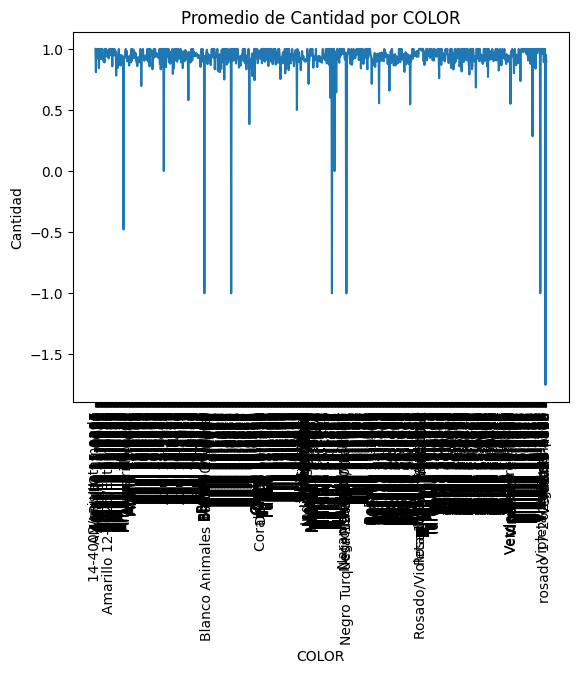

In [25]:
df.groupby("COLOR")["Cantidad"].mean().reset_index().pipe(
    lambda df: sns.lineplot(data=df, x="COLOR", y="Cantidad")
)
plt.xticks(rotation=90)
plt.title('Promedio de Cantidad por COLOR')
# Mostrar el gráfico
plt.show()

Note que hay algunos colores donde las cantidades pueden estar por debajo de 1, observemos unas cuantas.

In [26]:
df.groupby("COLOR")["Cantidad"].mean().reset_index().pipe(
    lambda df: df.sort_values(by="Cantidad", ascending=True).head(20)
)

,COLOR,Cantidad
1041,rosado 17-2625 estampado,-1.750000
314,Cafe 18-1031,-1.000000
252,Beige 14-6305,-1.000000
547,Naranja 16-1441,-1.000000
1029,Violeta 19-3642,-1.000000
580,Negro 19-6400 Lavado,-1.000000
581,Negro Turquesa 19-6400/16-4535,-1.000000
65,Amarillo 14-1045,-0.478261
158,Azul 17-4716,0.000000
553,Naranja 16-1462,0.000000


La tabla anterior muestra que estos colores presentan cantidades negativas o cero en promedio, y si quisiera predecir las cantidades esta información se debería tener en cuenta.

Por ultimo observemos los Materiales vs. Cantidades.

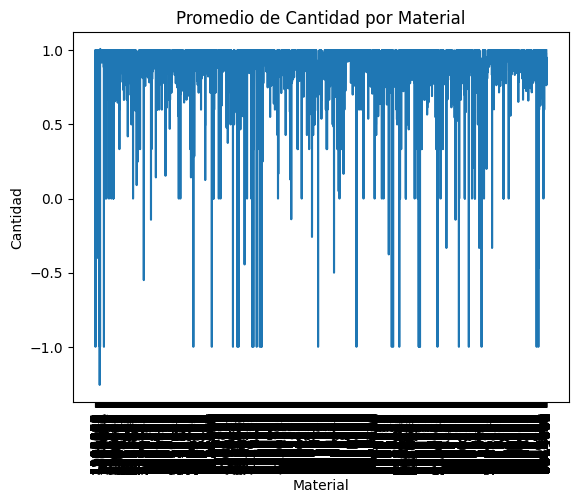

In [27]:
df.groupby("Material")["Cantidad"].mean().reset_index().pipe(
    lambda df: sns.lineplot(data=df, x="Material", y="Cantidad")
)
plt.xticks(rotation=90)
plt.title('Promedio de Cantidad por Material')
# Mostrar el gráfico
plt.show()

Note que no todos los materiales presentan cantidades de 1, muchos también presentan cantidades de 0 y -1 en promedio, para un modelo predictivo esto también es información relevante, echemos un vistazo a estos materiales.

In [28]:
df.groupby("Material")["Cantidad"].mean().reset_index().pipe(
    lambda df: df.sort_values(by="Cantidad", ascending=True).head(20)
)

,Material,Cantidad
108,1700142,-1.257143
3638,4113880,-1.000000
8225,5133696,-1.000000
117,1800435,-1.000000
4178,4133100,-1.000000
11215,5254069,-1.000000
9240,5202363,-1.000000
9492,5205588,-1.000000
8219,5133677,-1.000000
7723,5113936,-1.000000


La tabla anterior muestra en promedio las cantidades por material, ordenados por cantidad y solo los primeros 20 materiales, ya que son más de 11 mil, note que esta también es una variable importante si se quiere determinar o predecir la cantidad.

### Resumen de la exploración:

He notado que la importancia de algunas características que pueden ayudar a predecir la cantidad, por ejemplo, tener en la tienda (Centro), Color, Material y un poco el artículo, variables que nos pueden ayudar a predecir la cantidad, a continuación procederé a crear modelos analíticos.

## Creación de modelos

Antes de aplicar cualquier algoritmo, debemos balancear las muestras, por ende comencemos con esto.

In [29]:
df_pro = df.copy()

In [30]:
del df_pro["Cantidad"] # Eliminamos la variable Cantidad para evitar problemas de multicolinealidad
df_pro.dropna(inplace=True) # Eliminamos los registros con valores nulos

In [31]:
X = df_pro[["Año/Mes", "Centro", "Artículo", "TALLA", "COLOR", "Material"]]
y = df_pro["Re_cantidad"]

In [32]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [33]:
X_resampled.nunique()

Año/Mes       25
Centro       127
Artículo      35
TALLA         81
COLOR        898
Material    8133
dtype: int64

Dado que tengo muchas categorias usaré hashing trick, es un método de transformación que utiliza una función hash para asignar cada valor único de una característica a un índice en un vector de características de longitud fija. Esto significa que, en lugar de crear una columna separada para cada valor único de la característica, como en el caso de OneHotEncoder, FeatureHasher mapea directamente los valores a un espacio de características de menor dimensión

In [34]:
import pandas as pd
from sklearn.feature_extraction import FeatureHasher

# Suponiendo que X_resampled es tu DataFrame
# Convertir cada columna a una lista de listas de cadenas
columnas_lista = []
for columna in X_resampled.columns:
    columnas_lista.append([str(valor) for valor in X_resampled[columna]])

# Crear y ajustar el FeatureHasher para cada columna
hashed_dfs = {}
for i, columna in enumerate(X_resampled.columns):
    hasher = FeatureHasher(n_features=3, input_type='string')  # Cambiar n_features a 25
    hashed_features = hasher.transform([[str(valor)] for valor in X_resampled[columna]])
    hashed_df = pd.DataFrame(hashed_features.toarray(), columns=[f'{columna}_hash{i+1}' for i in range(3)])
    hashed_dfs[columna] = hashed_df

# Concatenar los DataFrames hash para cada columna
hashed_df = pd.concat(hashed_dfs.values(), axis=1)

Procedo a desarrollar un pipeline donde voy a orquestar distintos algoritmos de machine learning con distintos hiperparámetros para cada algoritmo, al final seleccionaré el mejor modelo teniendo en cuenta la precisión y curva ROC.

In [49]:
# Supongo que hashed_df y y_resampled ya están definidos
X_train, X_test, y_train, y_test = train_test_split(hashed_df, y_resampled, test_size=0.3, random_state=42)
y_train_bin = y_train.map({'Cant_neg': 0, 'Cant_pos': 1})
y_test_bin = y_test.map({'Cant_neg': 0, 'Cant_pos': 1})

In [36]:
from sklearn.metrics import accuracy_score

In [50]:
# Entrenar el modelo de regresión logística
log_reg = LogisticRegression(C=1)  
log_reg.fit(X_train, y_train)

# Hacer predicciones
y_pred_log_reg = log_reg.predict(X_test)

# Evaluar el modelo
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Precisión de Logistic Regression: {accuracy_log_reg:.2f}")


Precisión de Logistic Regression: 0.60


In [51]:
# Entrenar el modelo de K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train, y_train)

# Hacer predicciones
y_pred_knn = knn.predict(X_test)

# Evaluar el modelo
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Precisión de K-Nearest Neighbors: {accuracy_knn:.2f}")


Precisión de K-Nearest Neighbors: 0.57


In [52]:
# Entrenar el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100)  
rf.fit(X_train, y_train)

# Hacer predicciones
y_pred_rf = rf.predict(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Precisión de Random Forest: {accuracy_rf:.2f}")


Precisión de Random Forest: 0.60


In [53]:
from sklearn.naive_bayes import GaussianNB

# Entrenar el modelo de Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Hacer predicciones
y_pred_nb = nb.predict(X_test)

# Evaluar el modelo
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Precisión de Naive Bayes: {accuracy_nb:.2f}")

Precisión de Naive Bayes: 0.61


In [54]:
from sklearn.tree import DecisionTreeClassifier

# Entrenar el modelo de Decision Tree
dt = DecisionTreeClassifier() 
dt.fit(X_train, y_train)

# Hacer predicciones
y_pred_dt = dt.predict(X_test)

# Evaluar el modelo
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Precisión de Decision Tree: {accuracy_dt:.2f}")


Precisión de Decision Tree: 0.59


Pareciera que la precisión es un poco mejor cuando hablamos de naive bayes, observaremos la curva ROC.

In [55]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

# Calcular las probabilidades
y_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_prob_knn = knn.predict_proba(X_test)[:, 1]
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_prob_dt = dt.predict_proba(X_test)[:, 1]
y_prob_nb = nb.predict_proba(X_test)[:, 1]

In [56]:
# Calcular las curvas ROC y AUC
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test_bin, y_prob_log_reg)
roc_auc_log_reg = roc_auc_score(y_test_bin, y_prob_log_reg)

fpr_knn, tpr_knn, _ = roc_curve(y_test_bin, y_prob_knn)
roc_auc_knn = roc_auc_score(y_test_bin, y_prob_knn)

fpr_rf, tpr_rf, _ = roc_curve(y_test_bin, y_prob_rf)
roc_auc_rf = roc_auc_score(y_test_bin, y_prob_rf)

fpr_dt, tpr_dt, _ = roc_curve(y_test_bin, y_prob_dt)
roc_auc_dt = roc_auc_score(y_test_bin, y_prob_dt)

fpr_nb, tpr_nb, _ = roc_curve(y_test_bin, y_prob_nb)
roc_auc_nb = roc_auc_score(y_test_bin, y_prob_nb)



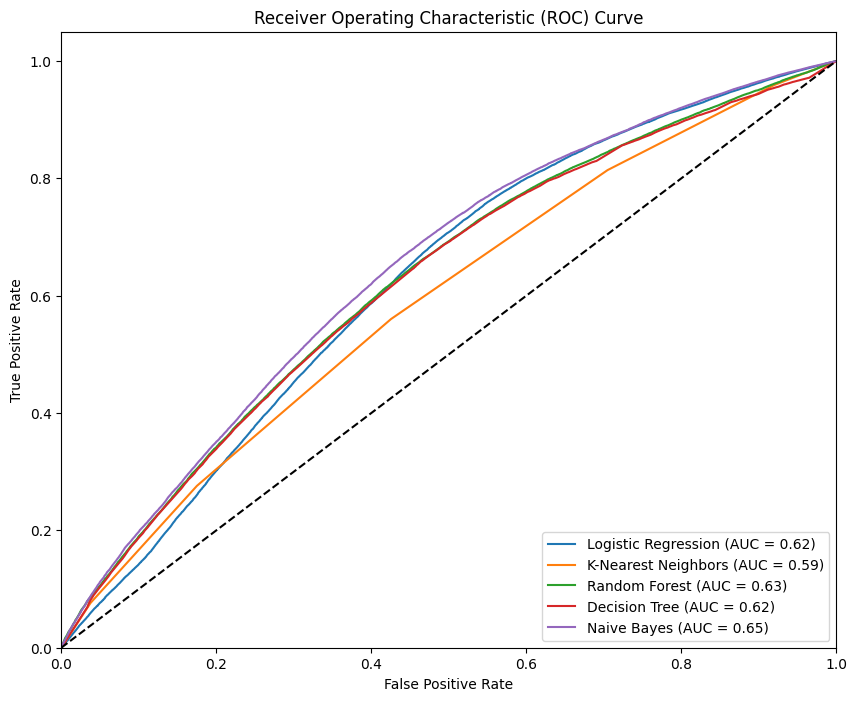

In [57]:
# Graficar las curvas ROC
plt.figure(figsize=(10, 8))

plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Conclusión
He elegido el modelo de Naive Bayes por las siguientes razones:

- Rendimiento Consistente: Tiene una precisión y AUC competitivas en comparación con otros modelos.  
- Eficiencia Computacional: Es rápido de entrenar y predecir, adecuado para grandes conjuntos de datos y recursos limitados.  
- Simplicidad y Facilidad de Interpretación: Es fácil de entender y explicar, especialmente para audiencias no técnicas. 

En resumen, Naive Bayes ofrece un buen equilibrio entre rendimiento, eficiencia y simplicidad, siendo una opción práctica y efectiva para este problema.

Muchas Gracias.
